In [2]:


import pandas as pd
# 1. Dosya adını buraya tam olarak indirdiğin gibi yazıyoruz
# (Senin yüklediğin dosya ismini kullandım)
dosya_adi = "Timeseries_38.496_27.707_SA3_6kWp_crystSi_14_35deg_0deg_2020_2023.csv"

# 2. Dosyayı okuma (PVGIS dosyalarının ilk 10 satırı açıklamadır, onları atlıyoruz)
try:
    df = pd.read_csv(dosya_adi, skiprows=10)
    
    # Alt kısımdaki açıklama satırlarını temizlemek için 'time' sütunu tarih olmayanları atıyoruz
    # (Hata verirse o satırı 'NaT' yapar, sonra da sileriz)
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M', errors='coerce')
    df = df.dropna(subset=['time'])

    # 3. Sütun isimlerini anlaşılır hale getirme (Mapping)
    sutun_isimleri = {
        'P': 'Uretim_W',           # Üretilen Güç (Watt) - HEDEF DEĞİŞKEN
        'Gb(i)': 'Direkt_Isinim',  # Doğrudan Güneş Işınımı
        'Gd(i)': 'Yayili_Isinim',  # Difüz (Yayılı) Işınım
        'Gr(i)': 'Yansiyan_Isinim',# Yansıyan Işınım
        'H_sun': 'Gunes_Yuksekligi',
        'T2m': 'Sicaklik_C',       # Sıcaklık
        'WS10m': 'Ruzgar_Hizi'     # Rüzgar Hızı
    }
    df.rename(columns=sutun_isimleri, inplace=True)

    # 4. Veri Tiplerini Garantiye Alma (Sayısal olması gerekenleri sayıya çeviriyoruz)
    sayisal_sutunlar = ['Uretim_W', 'Direkt_Isinim', 'Yayili_Isinim', 
                        'Yansiyan_Isinim', 'Gunes_Yuksekligi', 'Sicaklik_C', 'Ruzgar_Hizi']
    
    for col in sayisal_sutunlar:
        df[col] = pd.to_numeric(df[col])

    # 5. Feature Engineering: Toplam Global Işınımı hesaplama
    # Model için önemli: Panelin üzerine düşen toplam ışık gücü
    df['Global_Isinim'] = df['Direkt_Isinim'] + df['Yayili_Isinim'] + df['Yansiyan_Isinim']

    # İndeksi zaman yapalım
    df.set_index('time', inplace=True)
    
    # Gereksiz 'Int' sütunu varsa silelim
    if 'Int' in df.columns:
        df.drop(columns=['Int'], inplace=True)

    # 6. Temizlenmiş veriyi YENİ bir dosya olarak kaydetme
    cikti_ismi = "temiz_solar_veri.csv"
    df.to_csv(cikti_ismi)
    
    print(f"İşlem Başarılı! '{cikti_ismi}' dosyası oluşturuldu.")
    print("Veri Seti İlk 5 Satır:")
    print(df.head())

except FileNotFoundError:
    print("HATA: Dosya bulunamadı. Lütfen 'dosya_adi' kısmına indirdiğin dosyanın tam adını yazdığından emin ol.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")

İşlem Başarılı! 'temiz_solar_veri.csv' dosyası oluşturuldu.
Veri Seti İlk 5 Satır:
                     Uretim_W  Direkt_Isinim  Yayili_Isinim  Yansiyan_Isinim  \
time                                                                           
2020-01-01 00:10:00       0.0            0.0            0.0              0.0   
2020-01-01 01:10:00       0.0            0.0            0.0              0.0   
2020-01-01 02:10:00       0.0            0.0            0.0              0.0   
2020-01-01 03:10:00       0.0            0.0            0.0              0.0   
2020-01-01 04:10:00       0.0            0.0            0.0              0.0   

                     Gunes_Yuksekligi  Sicaklik_C  Ruzgar_Hizi  Global_Isinim  
time                                                                           
2020-01-01 00:10:00               0.0        0.17         0.83            0.0  
2020-01-01 01:10:00               0.0       -0.74         0.83            0.0  
2020-01-01 02:10:00               0.

Model eğitiliyor... (Bu işlem bilgisayar hızına göre 10-30 saniye sürebilir)
------------------------------
Model Başarısı (R²): %99.99
Ortalama Hata (MAE): 6.17 Watt
Karekök Hata (RMSE): 14.18 Watt
------------------------------


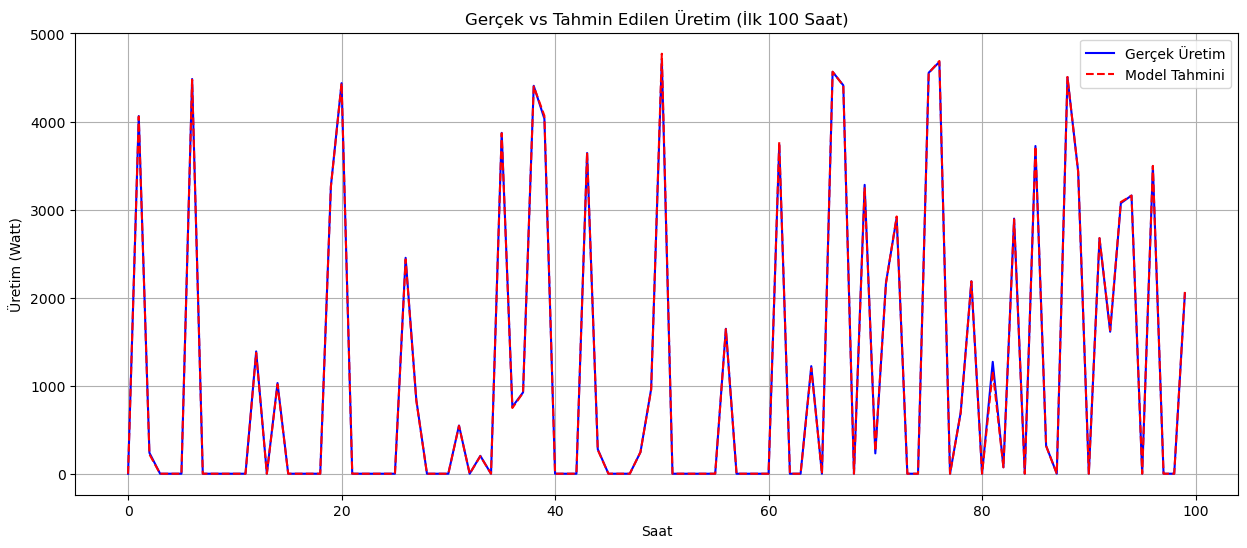

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Temizlenmiş veriyi yükle
df = pd.read_csv('temiz_solar_veri.csv', index_col='time', parse_dates=True)

# 2. Girdileri (X) ve Hedefi (y) Belirle
# Model şunlara bakacak: Sıcaklık, Toplam Işınım, Rüzgar, Güneş Yüksekliği
X = df[['Sicaklik_C', 'Global_Isinim', 'Ruzgar_Hizi', 'Gunes_Yuksekligi']]

# Model şunu tahmin etmeye çalışacak: Üretilen Güç
y = df['Uretim_W']

# 3. Veriyi Bölme (Eğitim ve Test)
# Verinin %80'i ile ders çalışacak, %20'si ile sınav olacak.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Model eğitiliyor... (Bu işlem bilgisayar hızına göre 10-30 saniye sürebilir)")

# 4. Modeli Oluştur ve Eğit (Random Forest)
# n_estimators=100: 100 tane karar ağacı kullan demek.
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Test Et (Tahmin Yap)
tahminler = model.predict(X_test)

# 6. Başarıyı Ölç (Metrikler)
mae = mean_absolute_error(y_test, tahminler)
rmse = np.sqrt(mean_squared_error(y_test, tahminler))
r2 = r2_score(y_test, tahminler)

print("-" * 30)
print(f"Model Başarısı (R²): %{r2*100:.2f}") # 100'e ne kadar yakınsa o kadar iyi
print(f"Ortalama Hata (MAE): {mae:.2f} Watt") # Tahminleri ortalama kaç Watt şaşıyor?
print(f"Karekök Hata (RMSE): {rmse:.2f} Watt")
print("-" * 30)

# 7. Sonuçları Grafikte Göster (İlk 100 saatlik kesit)
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Gerçek Üretim', color='blue')
plt.plot(tahminler[:100], label='Model Tahmini', color='red', linestyle='--')
plt.title('Gerçek vs Tahmin Edilen Üretim (İlk 100 Saat)')
plt.xlabel('Saat')
plt.ylabel('Üretim (Watt)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
import joblib
# NOT: Eğer modelinizin adı farklıysa (örneğin rf_uretim), aşağıdaki satırı ona göre değiştirin.
# joblib.dump(rf_uretim, 'uretim_tahmin_modeli.joblib')

joblib.dump(model_uretim, 'uretim_tahmin_modeli.joblib')
print("✅ Üretim Tahmin Modeli Kaydedildi: uretim_tahmin_modeli.joblib")

NameError: name 'model_uretim' is not defined

In [3]:
pip install joblib


Note: you may need to restart the kernel to use updated packages.


In [1]:
import joblib
# NOT: Eğer modelinizin adı farklıysa (örneğin rf_uretim), aşağıdaki satırı ona göre değiştirin.
# joblib.dump(rf_uretim, 'uretim_tahmin_modeli.joblib')

joblib.dump(model_uretim, 'uretim_tahmin_modeli.joblib')
print("✅ Üretim Tahmin Modeli Kaydedildi: uretim_tahmin_modeli.joblib")


NameError: name 'model_uretim' is not defined